## Cryptocurrency Research

**Context:** Before attempting to develop cryptocurrency trading strategies, I want to do some quantitative analysis of historical returns, volatility, return distributions, etc.

_Author: Matthew Garton_  
_June 8th, 2021_

In [67]:
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from utils.data_ingestion import get_crypto_prices

In [64]:
cryptos = ['BTC', 'ETH', 'XRP', 'LTC']

cc_data = {c: get_crypto_prices(c, 'USD', source='av') for c in cryptos}

In [31]:
BTC = cc_data['BTC']['4a. close (USD)']
ETH = cc_data['ETH']['4a. close (USD)']
XRP = cc_data['XRP']['4a. close (USD)']
LTC = cc_data['LTC']['4a. close (USD)']
XMR = cc_data['XMR']['4a. close (USD)']

In [36]:
coins = pd.concat([BTC, ETH, XRP, LTC, XMR], axis=1)

In [39]:
coins.columns = cryptos

In [42]:
coins.drop(columns=['XMR'], inplace=True)

Not enough data for XMR

In [45]:
daily_ret = coins.pct_change().dropna()

In [47]:
corrmatrix = daily_ret.corr()

In [48]:
corrmatrix

,BTC,ETH,XRP,LTC
BTC,1.00000,0.808900,0.547120,0.786200
ETH,0.80890,1.000000,0.615701,0.828759
XRP,0.54712,0.615701,1.000000,0.623344
LTC,0.78620,0.828759,0.623344,1.000000


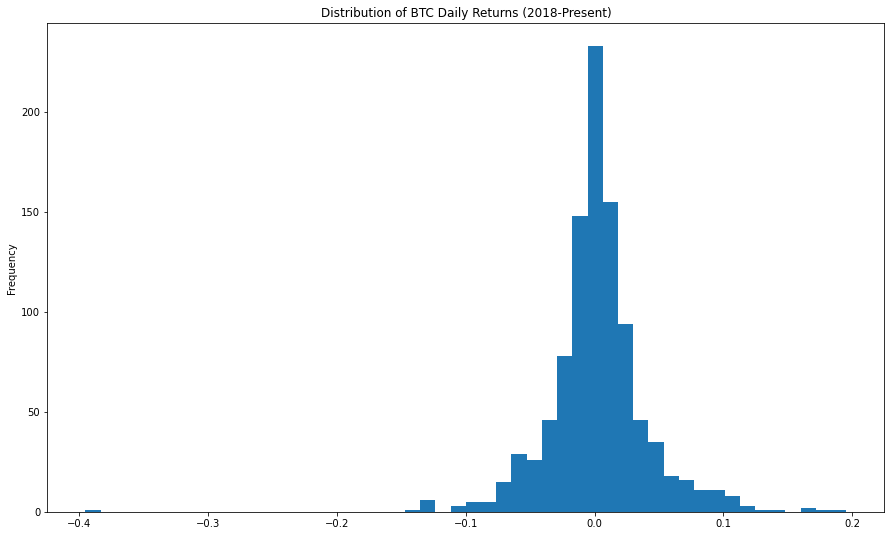

In [52]:
daily_ret['BTC'].plot(kind='hist', bins=50, figsize=(15, 9), title='Distribution of BTC Daily Returns (2018-Present)');

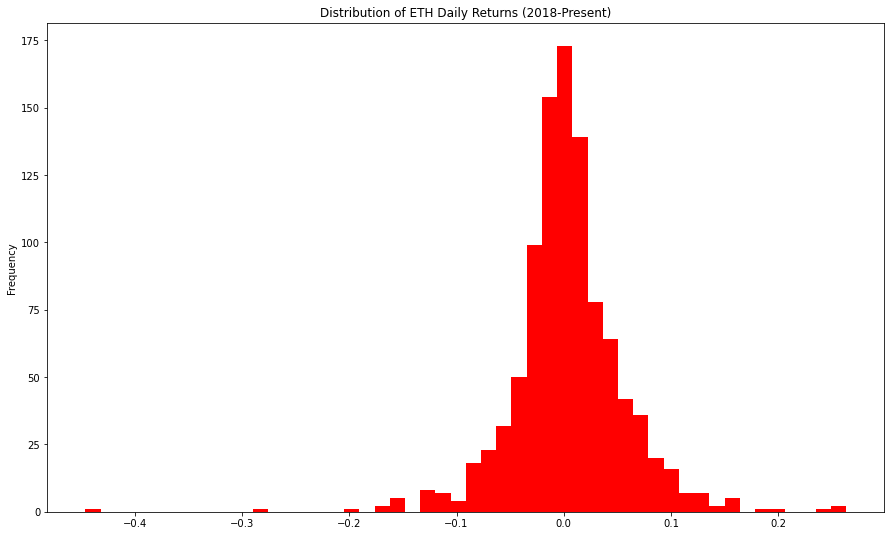

In [53]:
daily_ret['ETH'].plot(kind='hist', color='r', bins=50, figsize=(15, 9), title='Distribution of ETH Daily Returns (2018-Present)');

In [60]:
from scipy.stats import skew, kurtosis
from pprint import PrettyPrinter

pp = PrettyPrinter(indent=4, sort_dicts=False)

In [65]:
for c in cryptos:
    data = daily_ret[c]
    res = {
        c: {
            'Mean: ': np.round(np.mean(data), 4),
            'Standard Deviation: ': np.round(np.std(data), 4),
            'Skew': np.round(skew(data), 4),
            'Kurtosis': np.round(kurtosis(data), 4)
        } 
    }
    pp.pprint(res)

{   'BTC': {   'Mean: ': 0.0025,
               'Standard Deviation: ': 0.0395,
               'Skew': -0.6626,
               'Kurtosis': 12.3527}}
{   'ETH': {   'Mean: ': 0.0039,
               'Standard Deviation: ': 0.0523,
               'Skew': -0.4402,
               'Kurtosis': 8.3452}}
{   'XRP': {   'Mean: ': 0.0032,
               'Standard Deviation: ': 0.0652,
               'Skew': 1.6189,
               'Kurtosis': 16.2127}}
{   'LTC': {   'Mean: ': 0.0027,
               'Standard Deviation: ': 0.0558,
               'Skew': -0.0606,
               'Kurtosis': 6.8823}}


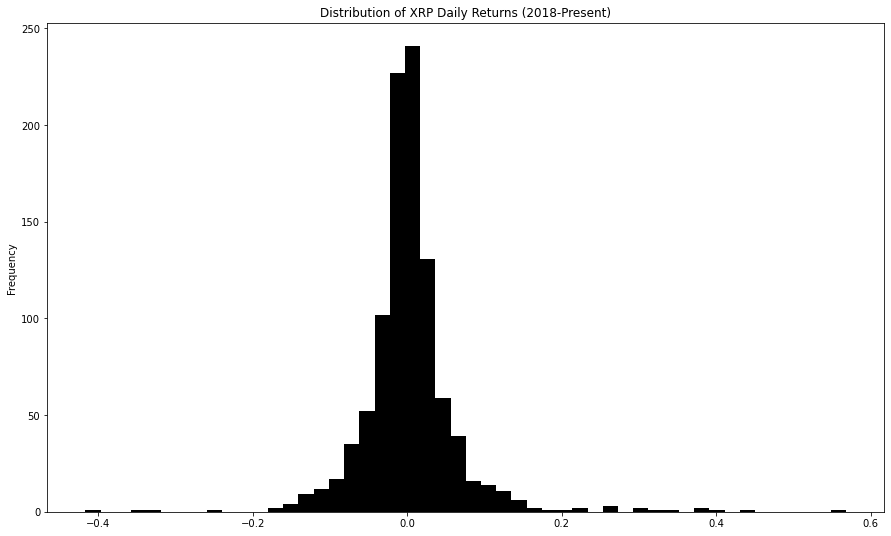

In [66]:
daily_ret['XRP'].plot(kind='hist', color='k', bins=50, figsize=(15, 9), title='Distribution of XRP Daily Returns (2018-Present)');

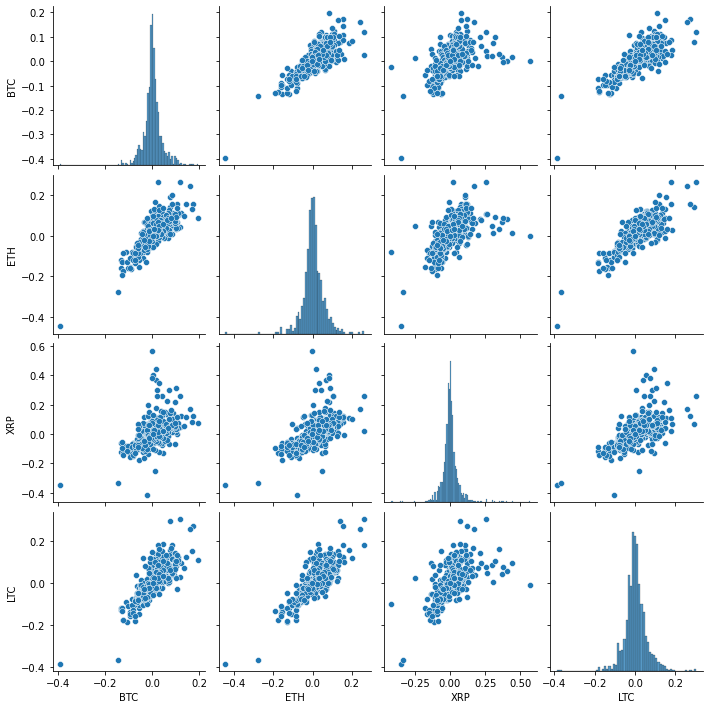

In [73]:
sns.pairplot(daily_ret);

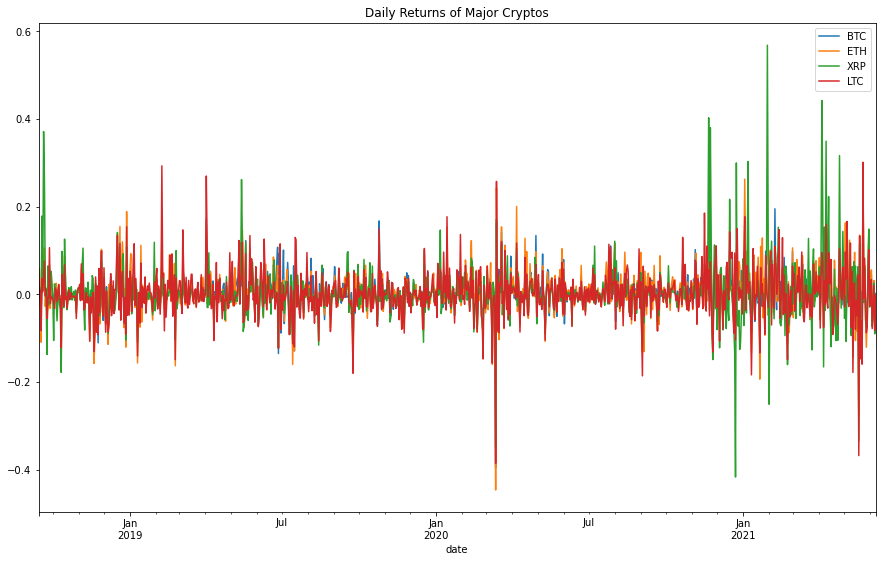

In [76]:
daily_ret.plot(figsize=(15,9), title='Daily Returns of Major Cryptos');

### Alternative Data Source: CoinAPI

In [13]:
params = {
    'asset_id_base': 'BTC',
    'asset_id_quote': 'USD',
    'period_id': '1DAY',
    'time_start': '2020-01-01T00:00:00',
    'time_end': '2021-06-04T00:00:00'
}

def generate_request(params):
    url = 'https://rest.coinapi.io/v1/exchangerate/BTC/USD/history?period_id=1DAY&time_start=2010-01-01T00:00:00&time_end=2021-06-04T00:00:00&limit=100000'
    headers = {'X-CoinAPI-Key' : os.getenv('COINAPI_KEY')}
    return requests.get(url, headers=headers)

In [14]:
res = generate_request(params)

In [15]:
df = pd.DataFrame(res.json())

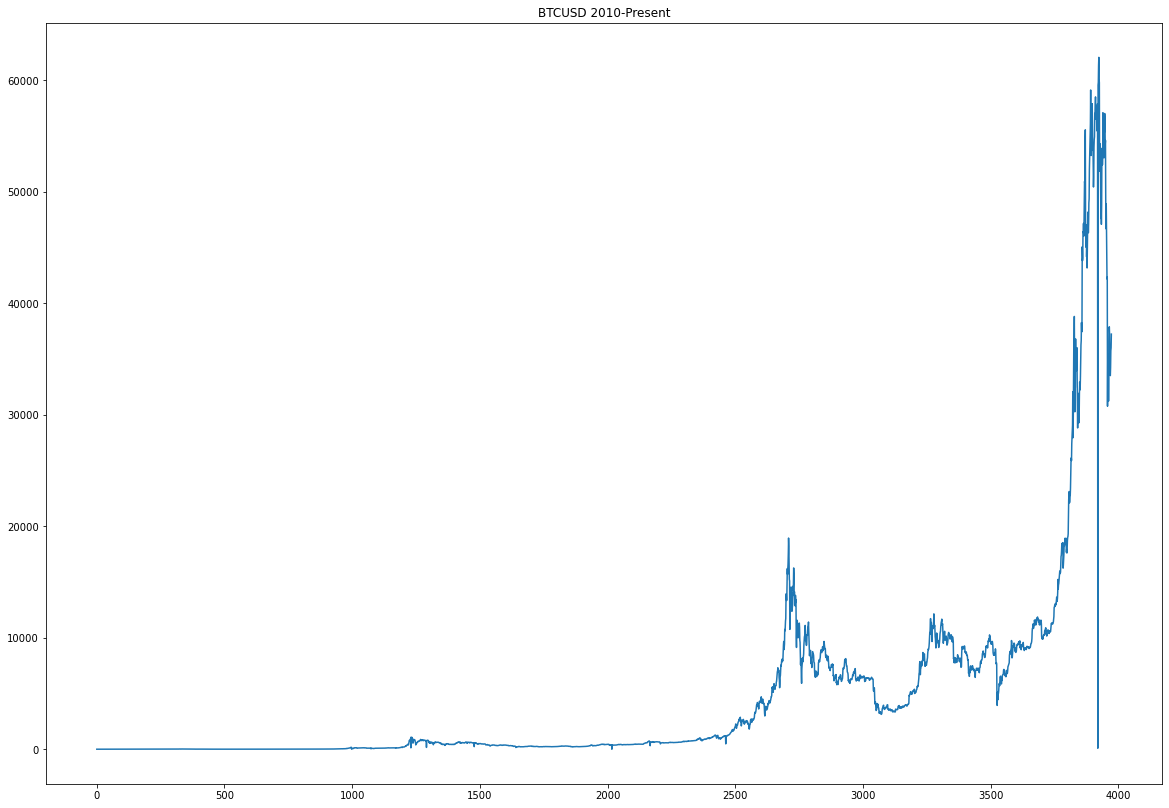

In [23]:
df['rate_low'].plot(figsize=(20,14), title='BTCUSD 2010-Present');

In [25]:
df.head()

,time_period_start,time_period_end,time_open,time_close,rate_open,rate_high,rate_low,rate_close
0,2010-07-18T00:00:00.0000000Z,2010-07-19T00:00:00.0000000Z,2010-07-18T17:48:00.0000000Z,2010-07-18T22:00:00.0000000Z,0.05941,0.08585,0.05941,0.08585
1,2010-07-19T00:00:00.0000000Z,2010-07-20T00:00:00.0000000Z,2010-07-19T16:24:00.0000000Z,2010-07-19T21:02:00.0000000Z,0.09090,0.09307,0.07723,0.07723
2,2010-07-20T00:00:00.0000000Z,2010-07-21T00:00:00.0000000Z,2010-07-20T03:54:00.0000000Z,2010-07-20T21:29:00.0000000Z,0.08181,0.08181,0.07426,0.07472
3,2010-07-21T00:00:00.0000000Z,2010-07-22T00:00:00.0000000Z,2010-07-21T02:30:00.0000000Z,2010-07-21T23:54:00.0000000Z,0.07425,0.07921,0.06634,0.07921
4,2010-07-22T00:00:00.0000000Z,2010-07-23T00:00:00.0000000Z,2010-07-22T00:50:00.0000000Z,2010-07-22T23:56:00.0000000Z,0.07921,0.08181,0.05446,0.05941


In [26]:
btc = df[['time_close', 'rate_open', 'rate_high', 'rate_low', 'rate_close']]

In [27]:
btc.set_index()

,time_close,rate_open,rate_high,rate_low,rate_close
0,2010-07-18T22:00:00.0000000Z,0.05941,0.08585,0.05941,0.08585
1,2010-07-19T21:02:00.0000000Z,0.09090,0.09307,0.07723,0.07723
2,2010-07-20T21:29:00.0000000Z,0.08181,0.08181,0.07426,0.07472
3,2010-07-21T23:54:00.0000000Z,0.07425,0.07921,0.06634,0.07921
4,2010-07-22T23:56:00.0000000Z,0.07921,0.08181,0.05446,0.05941
